# Régression Quantile : Application sur le Dataset de Risque de Crédit

## Introduction Mathématique

La **régression quantile** est une extension de la régression linéaire et/ou polynomiale qui modélise les quantiles conditionnels de la variable de réponse plutôt que sa moyenne conditionnelle.

### Définition mathématique

Pour un quantile $\tau \in (0,1)$, la régression quantile résout le problème d'optimisation :

$$\hat{\beta}_\tau = \arg\min_{\beta} \sum_{i=1}^n \rho_\tau(y_i - x_i^T\beta)$$

où $\rho_\tau(u)$ est la **fonction de perte quantile** définie par :

$$\rho_\tau(u) = u(\tau - \mathbf{1}_{u < 0}) = \begin{cases} 
\tau u & \text{si } u \geq 0 \\
(\tau - 1) u & \text{si } u < 0
\end{cases}$$

## Application au Risque de Crédit

Ce notebook applique la régression quantile au dataset **Financial Risk for Loan Approval** pour modéliser la relation entre le ratio d'endettement et le score de risque, permettant :

1. **Estimation de scénarios de risque** (optimiste, central, pessimiste)
2. **Quantification de l'incertitude** dans l'évaluation du risque de crédit
3. **Construction d'intervalles de confiance** pour l'aide à la décision

In [55]:
# Imports et configuration
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..', 'src'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import du module de chargement des données
from data_loading import load_regression_data
from preprocessing import prepare_regression_data

## 1. Chargement et Exploration des Données

In [56]:
# Chargement du dataset réel
print("Chargement du dataset Financial Risk for Loan Approval...")
df_raw = load_regression_data()

print(f"Dataset original : {df_raw.shape[0]} observations, {df_raw.shape[1]} variables")

# Suppression de la variable temporelle ApplicationDate (comme dans l'EDA)
if 'ApplicationDate' in df_raw.columns:
    df_raw = df_raw.drop(columns=['ApplicationDate'])
    print("Variable ApplicationDate supprimée (série temporelle non nécessaire)")

# Définition de la variable cible
target_column = 'RiskScore'

print(f"\nVariables disponibles : {list(df_raw.columns)}")
print(f"\nPremières lignes du dataset:")
df_raw.head()

Chargement du dataset Financial Risk for Loan Approval...
Chargement du dataset de régression: /home/r-one/Documents/epita/stochastique/Prediction-Conforme-et-Regression-Quantile-sur-le-Risque-de-Credit/data/raw/Loan.csv
Dataset chargé: 20000 lignes, 36 colonnes
Dataset original : 20000 observations, 36 variables
Variable ApplicationDate supprimée (série temporelle non nécessaire)

Variables disponibles : ['Age', 'AnnualIncome', 'CreditScore', 'EmploymentStatus', 'EducationLevel', 'Experience', 'LoanAmount', 'LoanDuration', 'MaritalStatus', 'NumberOfDependents', 'HomeOwnershipStatus', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory', 'LoanPurpose', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'NetWorth', 'BaseInterestRate', 

,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,45,39948,617,Employed,Master,22,13152,48,Married,2,...,3329.000000,0.724972,11,126928,0.199652,0.227590,419.805992,0.181077,0,49.0
1,38,39709,628,Employed,Associate,15,26045,48,Single,1,...,3309.083333,0.935132,3,43609,0.207045,0.201077,794.054238,0.389852,0,52.0
2,47,40724,570,Employed,Bachelor,26,17627,36,Married,2,...,3393.666667,0.872241,6,5205,0.217627,0.212548,666.406688,0.462157,0,52.0
3,58,69084,545,Employed,High School,34,37898,96,Single,1,...,5757.000000,0.896155,5,99452,0.300398,0.300911,1047.506980,0.313098,0,54.0
4,37,103264,594,Employed,Associate,17,9184,36,Married,1,...,8605.333333,0.941369,5,227019,0.197184,0.175990,330.179140,0.070210,1,36.0


## 2. Rappel EDA : Corrélations avec la cible

On affiche la matrice de corrélation pour identifier les features les plus pertinentes

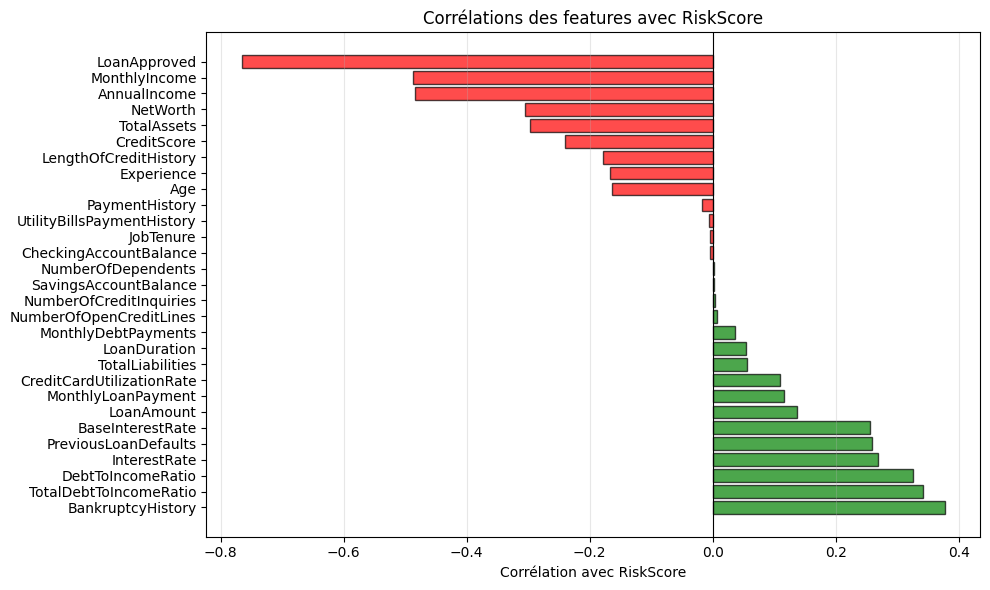


Corrélations (triées):
  BankruptcyHistory: 0.378
  TotalDebtToIncomeRatio: 0.343
  DebtToIncomeRatio: 0.327
  InterestRate: 0.268
  PreviousLoanDefaults: 0.259
  BaseInterestRate: 0.256
  LoanAmount: 0.138
  MonthlyLoanPayment: 0.116
  CreditCardUtilizationRate: 0.109
  TotalLiabilities: 0.056
  LoanDuration: 0.055
  MonthlyDebtPayments: 0.037
  NumberOfOpenCreditLines: 0.008
  NumberOfCreditInquiries: 0.003
  SavingsAccountBalance: 0.002
  NumberOfDependents: 0.002
  CheckingAccountBalance: -0.004
  JobTenure: -0.004
  UtilityBillsPaymentHistory: -0.005
  PaymentHistory: -0.017
  Age: -0.164
  Experience: -0.166
  LengthOfCreditHistory: -0.178
  CreditScore: -0.240
  TotalAssets: -0.297
  NetWorth: -0.304
  AnnualIncome: -0.483
  MonthlyIncome: -0.487
  LoanApproved: -0.766

Features numériques continues détectées (>20 valeurs uniques): ['Age', 'AnnualIncome', 'CreditScore', 'Experience', 'LoanAmount', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'DebtToIncomeRatio', 'Payment

In [57]:
# Calcul des corrélations avec RiskScore
numeric_features = [col for col in df_raw.select_dtypes(include=[np.number]).columns if col != target_column]
correlations = df_raw[numeric_features + [target_column]].corr()[target_column].drop(target_column)
correlations_sorted = correlations.sort_values(ascending=False)

# Visualisation
plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in correlations_sorted.values]
plt.barh(range(len(correlations_sorted)), correlations_sorted.values, color=colors, alpha=0.7, edgecolor='black')
plt.yticks(range(len(correlations_sorted)), correlations_sorted.index)
plt.xlabel(f'Corrélation avec {target_column}')
plt.title(f'Corrélations des features avec {target_column}')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nCorrélations (triées):")
for var, corr in correlations_sorted.items():
    print(f"  {var}: {corr:.3f}")
    
# Identifier la feature numérique continue la plus corrélée
# On exclut les variables binaires ou discrètes
continuous_features = []
for col in numeric_features:
    n_unique = df_raw[col].nunique()
    # On considère qu'une variable est continue si elle a plus de 20 valeurs uniques
    if n_unique > 20:
        continuous_features.append(col)

print(f"\nFeatures numériques continues détectées (>20 valeurs uniques): {continuous_features}")

# Trouver la plus corrélée parmi les continues
correlations_continuous = correlations[correlations.index.isin(continuous_features)]
if len(correlations_continuous) > 0:
    most_correlated_continuous = correlations_continuous.abs().idxmax()
    print(f"\nFeature continue la plus corrélée: {most_correlated_continuous} (corr = {correlations[most_correlated_continuous]:.3f})")
else:
    # Fallback: prendre la plus corrélée parmi toutes les numériques
    most_correlated_continuous = correlations.abs().idxmax()
    print(f"\nFeature numérique la plus corrélée: {most_correlated_continuous} (corr = {correlations[most_correlated_continuous]:.3f})")

## 3. Protocole de Régression Quantile : Justification des 3 Modèles

### Objectif de la Régression Quantile

La régression quantile ne modélise pas seulement la **moyenne conditionnelle** (comme la régression linéaire classique) mais les **quantiles conditionnels** de la distribution de la variable cible.

**Pourquoi 3 modèles différents ?**

Nous allons comparer **3 configurations de features** pour évaluer l'impact du nombre de variables sur :
1. **La précision des prédictions** (erreur médiane)
2. **La calibration des intervalles** (taux de couverture)
3. **La largeur des intervalles de prédiction** (incertitude quantifiée)

---

### Configuration des 3 Modèles

#### **Modèle 1 : Une seule feature (la plus corrélée)**
- **Avantage** : Simplicité, interprétabilité maximale, visualisation 2D possible
- **Inconvénient** : Capture une relation univariée, peut manquer des patterns multivariés

#### **Modèle 2 : Toutes les features disponibles**
- **Avantage** : Utilise toute l'information disponible, capture les interactions complexes
- **Inconvénient** : Risque de surapprentissage, plus difficile à interpréter

#### **Modèle 3 : Features modérément corrélées (|corr| >= 0.1)**
- **Avantage** : Compromis entre simplicité et performance, réduit le bruit
- **Inconvénient** : Dépend du seuil de corrélation choisi

---

### Choix des Quantiles : $\beta = 0.1$

Nous fixons **$\beta = 0.1$** pour obtenir un **intervalle de confiance à 90%**.

Ainsi, nous entraînons **3 régressions quantiles par modèle** :
- **$Q_{0.05}$** : Borne inférieure (scénario optimiste pour le risque)
- **$Q_{0.50}$** : Médiane conditionnelle (prédiction centrale)
- **$Q_{0.95}$** : Borne supérieure (scénario pessimiste pour le risque)

**Interprétation financière** :
- 90% des nouveaux clients devraient avoir un RiskScore dans l'intervalle prédit
- Permet d'évaluer le pire cas (Q95) pour la gestion du risque
- Plus robuste aux valeurs extrêmes que la moyenne conditionnelle

---

### Évaluation de la Performance : Coverage (Couverture)

Le **taux de couverture empirique** mesure si notre modèle est **bien calibré** :

$$\text{Coverage} = \frac{1}{n_{test}} \sum_{i=1}^{n_{test}} \mathbb{1}_{Q_{0.05}(y_i|X_i) \leq y_i \leq Q_{0.95}(y_i|X_i)}$$

**Critère de validation** :
- Si **Coverage ≈ 90%** → Modèle bien calibré
- Si **Coverage < 90%** → Intervalles trop étroits (sous-estimation de l'incertitude)
- Si **Coverage > 90%** → Intervalles trop larges (sur-estimation de l'incertitude)

Nous calculerons la couverture sur :
1. **Le jeu d'entraînement** (contrôle de sanity check)
2. **Le jeu de test** (évaluation réelle de la généralisation)

## 4. Préparation des Données

**Prétraitement appliqué :**
1. **One-hot encoding** : Les variables catégorielles (EmploymentStatus, EducationLevel, etc.) sont converties en variables binaires pour être utilisables par le modèle linéaire
2. **Normalisation (StandardScaler)** : Centrage et réduction des features pour :
   - Améliorer la convergence du solver
   - Rendre les coefficients comparables entre eux
   - Éviter que des features à grande échelle dominent le modèle

In [58]:
from sklearn.preprocessing import StandardScaler

# Appel de la fonction de preprocessing
X_train, X_test, y_train, y_test = prepare_regression_data(
    df_raw,
    target_column=target_column,
    test_size=0.33,  # 67% train, 33% test (comme dans le cours)
    random_state=42
)

print(f"\nAvant traitement: {X_train.shape}")
print(f"Types de données:\n{X_train.dtypes.value_counts()}")

# One-hot encoding des variables catégorielles
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
if categorical_cols:
    print(f"\nVariables catégorielles détectées: {categorical_cols}")
    X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
    X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)
    # Aligner les colonnes (au cas où certaines catégories manquent dans test)
    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)
    print(f"Après one-hot encoding: {X_train.shape}")

# Normalisation : Importante pour la régression quantile car elle est sensible à l'échelle
# Les features ont des échelles différentes (ex: revenu en milliers vs ratio en %)
# La normalisation améliore la convergence du solver et rend les coefficients comparables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reconvertir en DataFrame pour garder les noms de colonnes
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print(f"\nAprès normalisation: {X_train.shape}")
print("Données prêtes pour la régression quantile!")

Préparation des données de régression - Target: RiskScore
Statistiques de la variable cible:
count    20000.000000
mean        50.766780
std          7.778262
min         28.800000
25%         46.000000
50%         52.000000
75%         56.000000
max         84.000000
Name: RiskScore, dtype: float64
Données d'entraînement: (13400, 34)
Données de test: (6600, 34)

Avant traitement: (13400, 34)
Types de données:
int64      21
float64     8
object      5
Name: count, dtype: int64

Variables catégorielles détectées: ['EmploymentStatus', 'EducationLevel', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose']
Après one-hot encoding: (13400, 45)

Après normalisation: (13400, 45)
Données prêtes pour la régression quantile!


## 5. Entraînement des Régressions Quantiles

La régression quantile fitte un modèle linéaire sur la fonction quantile d'ordre $\tau$.

**Configuration :**
- $\beta=0.1$ pour obtenir une couverture d'ordre $1-\beta=0.9$ (donc une couverture à 90%)
- On veut un intervalle de prédiction symétrique, on fitte donc les quantiles d'ordre $\frac{\beta}{2}$ et $1-\frac{\beta}{2}$, qui entoure le quantile médian ($\tau=0.5$)

**Solveur utilisé :** `highs` (recommandé pour scipy >= 1.6.0, plus rapide et plus stable que `interior-point`)

In [ ]:
from sklearn.linear_model import QuantileRegressor

# Définition des quantiles d'intérêt
beta = 0.1
quantiles = [beta/2, 0.5, 1-beta/2]  # [0.05, 0.5, 0.95]

available_features = X_train.columns.tolist()

# Identifier les features numériques originales (avant one-hot encoding)
numeric_features_original = [col for col in df_raw.select_dtypes(include=[np.number]).columns 
                             if col != target_column and col in available_features]

# Si elles existent encore après le preprocessing
correlations_available = correlations[correlations.index.isin(numeric_features_original)]

if len(correlations_available) > 0:
    correlations_abs = correlations_available.abs().sort_values(ascending=False)
    
    # Sélectionner la feature continue la plus corrélée
    if most_correlated_continuous in available_features:
        most_correlated = most_correlated_continuous
    else:
        most_correlated = correlations_abs.index[0]
    
    # Features modérément corrélées
    moderately_correlated = correlations_abs[correlations_abs >= 0.1].index.tolist()
else:
    # Si pas de features numériques originales, prendre les premières features disponibles
    most_correlated = available_features[0]
    moderately_correlated = available_features[:min(10, len(available_features))]

print(f"Feature la plus corrélée (continue): {most_correlated} (corr = {correlations[most_correlated]:.3f})")
print(f"Features modérément corrélées (|corr| >= 0.1): {len(moderately_correlated)} features")
print(f"  → {moderately_correlated}")

# Préparation des 3 configurations de features
feature_configs = {
    'Modèle 1 (1 feature)': [most_correlated],
    'Modèle 2 (toutes features)': available_features,
    'Modèle 3 (features corrélées)': moderately_correlated
}

# Entraînement des modèles pour chaque configuration et quantile
models = {}
print("\n" + "="*60)
print("ENTRAÎNEMENT DES MODÈLES")
print("="*60)

for config_name, features in feature_configs.items():
    models[config_name] = {}
    print(f"\n{config_name}: entraînement sur {len(features)} features...")
    
    for q in quantiles:
        qr = QuantileRegressor(quantile=q, alpha=0, solver='highs')
        qr.fit(X_train[features], y_train)
        models[config_name][q] = qr
        print(f"  ✓ Quantile {q:.2f} entraîné")

print("\n Tous les modèles ont été entraînés avec succès!")

Feature la plus corrélée (continue): MonthlyIncome (corr = -0.487)
Features modérément corrélées (|corr| >= 0.1): 18 features
  → ['LoanApproved', 'MonthlyIncome', 'AnnualIncome', 'BankruptcyHistory', 'TotalDebtToIncomeRatio', 'DebtToIncomeRatio', 'NetWorth', 'TotalAssets', 'InterestRate', 'PreviousLoanDefaults', 'BaseInterestRate', 'CreditScore', 'LengthOfCreditHistory', 'Experience', 'Age', 'LoanAmount', 'MonthlyLoanPayment', 'CreditCardUtilizationRate']

ENTRAÎNEMENT DES MODÈLES

Modèle 1 (1 feature): entraînement sur 1 features...
  ✓ Quantile 0.05 entraîné
  ✓ Quantile 0.05 entraîné
  ✓ Quantile 0.50 entraîné
  ✓ Quantile 0.50 entraîné
  ✓ Quantile 0.95 entraîné

Modèle 2 (toutes features): entraînement sur 45 features...
  ✓ Quantile 0.95 entraîné

Modèle 2 (toutes features): entraînement sur 45 features...
  ✓ Quantile 0.05 entraîné
  ✓ Quantile 0.05 entraîné
  ✓ Quantile 0.50 entraîné
  ✓ Quantile 0.50 entraîné
  ✓ Quantile 0.95 entraîné

Modèle 3 (features corrélées): entraîne

## 6. Visualisation des Résultats

Comme dans le notebook du cours, nous visualisons :
1. **Modèle 1 (1 feature)** : Graph 2D montrant les 3 quantiles et l'intervalle de prédiction
2. **Modèles 2 et 3** : Scatter plot des prédictions vs valeurs réelles avec intervalles

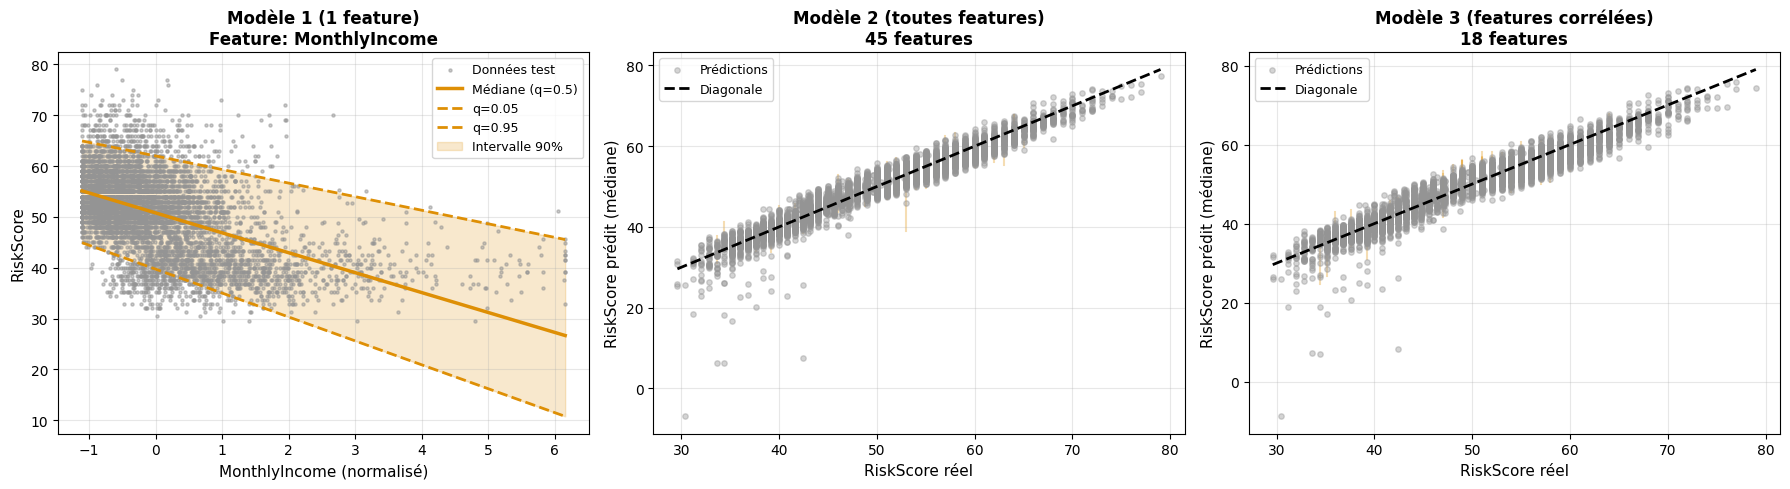

In [65]:
# Configuration des couleurs (comme dans le cours)
colors_blindness = sns.color_palette("colorblind")
color_train = colors_blindness[1]
color_test = colors_blindness[7]
color_true = colors_blindness[4]

# Visualisation pour le Modèle 1 (1 feature) - Graph 2D
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (config_name, features) in enumerate(feature_configs.items()):
    if idx == 0:  # Modèle 1 uniquement - visualisation 2D
        ax = axes[0]
        
        # Trier les données pour la visualisation
        X_plot = X_test[features].values.flatten()
        sort_idx = np.argsort(X_plot)
        X_sorted = X_plot[sort_idx]
        y_sorted = y_test.values[sort_idx]
        
        # Prédictions pour chaque quantile
        predictions = {}
        for q in quantiles:
            pred = models[config_name][q].predict(X_test[features])
            predictions[q] = pred[sort_idx]
        
        # Affichage (style du cours)
        ax.scatter(X_test[features], y_test, marker='.', color=color_test, alpha=0.5, s=20, label='Données test', zorder=2)
        ax.plot(X_sorted, predictions[0.5], '-', color=color_train, linewidth=2.5, label='Médiane (q=0.5)', zorder=3)
        ax.plot(X_sorted, predictions[0.05], '--', color=color_train, linewidth=2, label=f'q={quantiles[0]}', zorder=3)
        ax.plot(X_sorted, predictions[0.95], '--', color=color_train, linewidth=2, label=f'q={quantiles[2]}', zorder=3)
        ax.fill_between(X_sorted, predictions[0.05], predictions[0.95], alpha=0.2, color=color_train, label='Intervalle 90%', zorder=1)
        
        ax.set_xlabel(f'{features[0]} (normalisé)', fontsize=11)
        ax.set_ylabel(target_column, fontsize=11)
        ax.set_title(f'{config_name}\nFeature: {features[0]}', fontsize=12, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(alpha=0.3)

# Visualisation des prédictions pour tous les modèles
for idx, (config_name, features) in enumerate(feature_configs.items()):
    if idx > 0:  # Pour les modèles 2 et 3
        ax = axes[idx]
        
        # Prédictions sur le test set
        y_pred_median = models[config_name][0.5].predict(X_test[features])
        y_pred_lower = models[config_name][quantiles[0]].predict(X_test[features])
        y_pred_upper = models[config_name][quantiles[2]].predict(X_test[features])
        
        ax.scatter(y_test, y_pred_median, alpha=0.4, s=15, color=color_test, label='Prédictions', zorder=2)
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', linewidth=2, label='Diagonale', zorder=3)
        
        # Intervalles de prédiction (échantillon pour lisibilité)
        sample_size = min(50, len(y_test))
        sample_idx = np.random.choice(len(y_test), sample_size, replace=False)
        for i in sample_idx:
            ax.plot([y_test.iloc[i], y_test.iloc[i]], 
                   [y_pred_lower[i], y_pred_upper[i]], 
                   color=color_train, alpha=0.3, linewidth=1.5, zorder=1)
        
        ax.set_xlabel(f'{target_column} réel', fontsize=11)
        ax.set_ylabel(f'{target_column} prédit (médiane)', fontsize=11)
        ax.set_title(f'{config_name}\n{len(features)} features', fontsize=12, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Coverage

Le principal problème que nous allons rencontrer, c'est d'évaluer la couverture réelle du modèle. Autrement dit:
"Si j'ai de nouvelles données, est ce que mes intervalles de prédiction ont bien une couverture d'au moins 90%?"

In [66]:
# Calcul du coverage pour chaque modèle

print("="*70)
print("COVERAGE : ÉVALUATION DE LA COUVERTURE")
print("="*70)

# Compute and print theoretical and empirical coverage
theor_cov = 1 - beta
print(f"\nCouverture théorique attendue: {theor_cov*100:.1f}%")
print()

for config_name, features in feature_configs.items():
    print(f"\n{config_name}:")
    
    # Prédictions sur test
    y_pred_lower_test = models[config_name][quantiles[0]].predict(X_test[features])
    y_pred_upper_test = models[config_name][quantiles[2]].predict(X_test[features])
    
    # Count how many times the true label was indeed
    # in the prediction interval on the test set
    prop_covered_qr = np.sum((y_pred_lower_test <= y_test) & (y_test <= y_pred_upper_test)) / len(y_test)
    
    print(f"  Couverture empirique sur le test: {prop_covered_qr*100:.1f}%")

COVERAGE : ÉVALUATION DE LA COUVERTURE

Couverture théorique attendue: 90.0%


Modèle 1 (1 feature):
  Couverture empirique sur le test: 89.5%

Modèle 2 (toutes features):
  Couverture empirique sur le test: 88.9%

Modèle 3 (features corrélées):
  Couverture empirique sur le test: 88.9%


Calcul du coverage avec (200 itérations)...
Cela peut prendre quelques secondes...

Modèle 1 (1 feature): Coverage moyen = 89.45% ± 0.37%
Modèle 1 (1 feature): Coverage moyen = 89.45% ± 0.37%
Modèle 2 (toutes features): Coverage moyen = 88.86% ± 0.38%
Modèle 2 (toutes features): Coverage moyen = 88.86% ± 0.38%
Modèle 3 (features corrélées): Coverage moyen = 88.90% ± 0.38%
Modèle 3 (features corrélées): Coverage moyen = 88.90% ± 0.38%


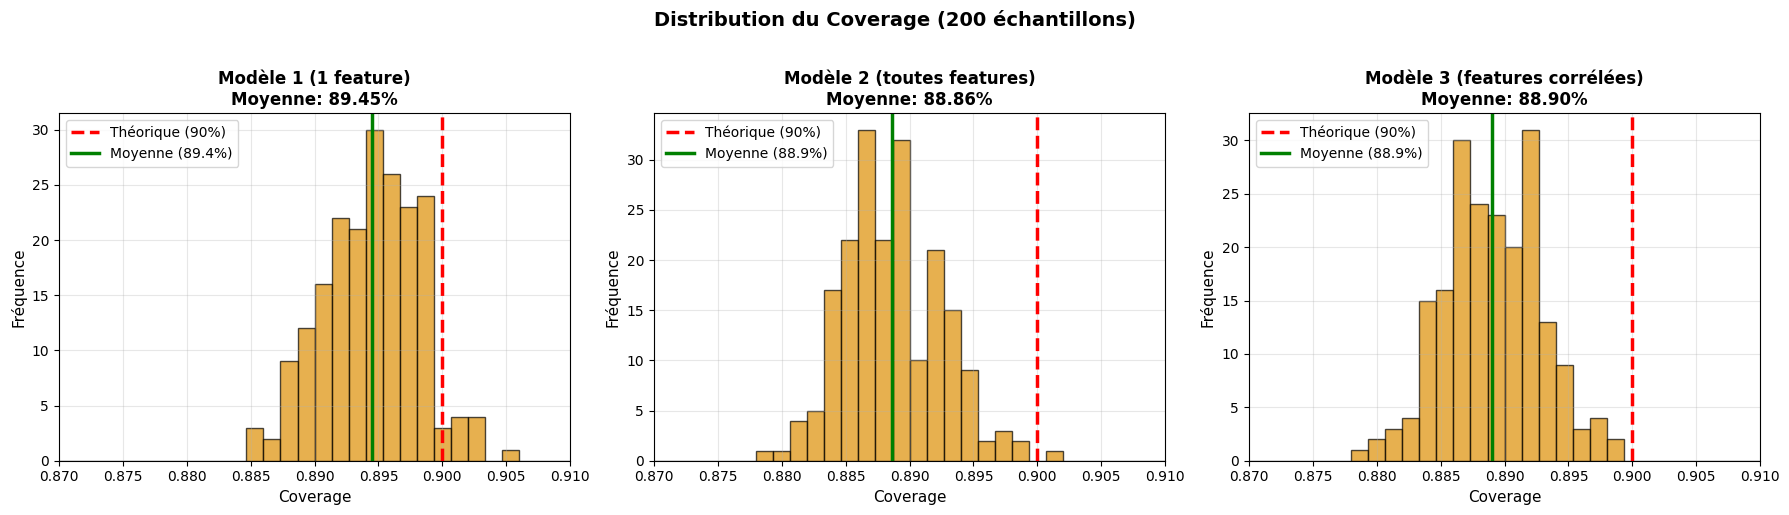


STATISTIQUES DES COVERAGES

Modèle 1 (1 feature):
  Moyenne: 89.45%
  Écart-type: 0.37%
  Min: 88.50%
  Max: 90.58%

Modèle 2 (toutes features):
  Moyenne: 88.86%
  Écart-type: 0.38%
  Min: 87.80%
  Max: 90.09%

Modèle 3 (features corrélées):
  Moyenne: 88.90%
  Écart-type: 0.38%
  Min: 87.89%
  Max: 89.86%


In [67]:
def coverage_bootstrap(config_name, features, n_iterations=200):
    """
    Calcule le coverage sur plusieurs échantillons bootstrap du test set
    pour évaluer la stabilité de la couverture
    """
    coverages = []
    
    for i in range(n_iterations):
        # Bootstrap : échantillonnage avec remplacement du test set
        bootstrap_idx = np.random.choice(len(y_test), size=len(y_test), replace=True)
        y_test_boot = y_test.iloc[bootstrap_idx]
        X_test_boot = X_test.iloc[bootstrap_idx]
        
        # Prédictions
        y_pred_lower = models[config_name][quantiles[0]].predict(X_test_boot[features])
        y_pred_upper = models[config_name][quantiles[2]].predict(X_test_boot[features])
        
        # Calcul du coverage
        coverage = np.sum((y_pred_lower <= y_test_boot) & (y_test_boot <= y_pred_upper)) / len(y_test_boot)
        coverages.append(coverage)
    
    return np.array(coverages)

# Calcul du coverage pour chaque modèle avec bootstrap
print("Calcul du coverage avec (200 itérations)...")
print("Cela peut prendre quelques secondes...\n")

bootstrap_results = {}
for config_name, features in feature_configs.items():
    coverages = coverage_bootstrap(config_name, features, n_iterations=200)
    bootstrap_results[config_name] = coverages
    print(f"{config_name}: Coverage moyen = {np.mean(coverages)*100:.2f}% ± {np.std(coverages)*100:.2f}%")



# Visualisation : Histogrammes de la distribution du coverage
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Définir une échelle commune pour faciliter la comparaison
xlim_min = 0.87  # 88%
xlim_max = 0.91  # 92%

for idx, (config_name, features) in enumerate(feature_configs.items()):
    ax = axes[idx]
    
    coverages = bootstrap_results[config_name]
    
    # Histogramme
    ax.hist(coverages, bins=30, color=color_train, alpha=0.7, edgecolor='black', range=(xlim_min, xlim_max))
    
    # Ligne verticale pour la couverture théorique
    ax.axvline(x=theor_cov, color='red', linestyle='--', linewidth=2.5, 
               label=f'Théorique ({theor_cov*100:.0f}%)')
    
    # Ligne verticale pour la moyenne empirique
    mean_cov = np.mean(coverages)
    ax.axvline(x=mean_cov, color='green', linestyle='-', linewidth=2.5, 
               label=f'Moyenne ({mean_cov*100:.1f}%)')
    
    ax.set_xlabel('Coverage', fontsize=11)
    ax.set_ylabel('Fréquence', fontsize=11)
    ax.set_title(f'{config_name}\nMoyenne: {mean_cov*100:.2f}%', 
                 fontsize=12, fontweight='bold')
    ax.set_xlim(xlim_min, xlim_max)  # Échelle commune pour tous les graphiques
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

plt.suptitle('Distribution du Coverage (200 échantillons)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("STATISTIQUES DES COVERAGES")
print("="*70)
for config_name in feature_configs.keys():
    coverages = bootstrap_results[config_name]
    print(f"\n{config_name}:")
    print(f"  Moyenne: {np.mean(coverages)*100:.2f}%")
    print(f"  Écart-type: {np.std(coverages)*100:.2f}%")
    print(f"  Min: {np.min(coverages)*100:.2f}%")
    print(f"  Max: {np.max(coverages)*100:.2f}%")


# Prédiction sur un nouveau client

In [63]:
# Prenons un exemple du test set
exemple_idx = 0
X_exemple = X_test.iloc[exemple_idx:exemple_idx+1]
y_reel = y_test.iloc[exemple_idx]

print("="*60)
print("PRÉDICTION POUR UN NOUVEAU CLIENT")
print("="*60)

# Utilisons le Modèle 2 (toutes les features) comme exemple
config_name = 'Modèle 2 (toutes features)'
features = feature_configs[config_name]

# Prédictions avec les 3 quantiles
pred_lower = models[config_name][quantiles[0]].predict(X_exemple[features])[0]
pred_median = models[config_name][0.5].predict(X_exemple[features])[0]
pred_upper = models[config_name][quantiles[2]].predict(X_exemple[features])[0]

print(f"\nValeur réelle du RiskScore: {y_reel:.2f}")
print(f"\nPrédictions:")
print(f"  Quantile 0.05 (scénario optimiste): {pred_lower:.2f}")
print(f"  Quantile 0.50 (médiane):            {pred_median:.2f}")
print(f"  Quantile 0.95 (scénario pessimiste): {pred_upper:.2f}")
print(f"\nIntervalle de prédiction à 90%: [{pred_lower:.2f}, {pred_upper:.2f}]")
print(f"Largeur de l'intervalle: {pred_upper - pred_lower:.2f}")

# Vérification
if pred_lower <= y_reel <= pred_upper:
    print(f"\n✅ La vraie valeur est dans l'intervalle prédit")
else:
    print(f"\n❌ La vraie valeur est HORS de l'intervalle prédit")

PRÉDICTION POUR UN NOUVEAU CLIENT

Valeur réelle du RiskScore: 41.60

Prédictions:
  Quantile 0.05 (scénario optimiste): 40.15
  Quantile 0.50 (médiane):            42.52
  Quantile 0.95 (scénario pessimiste): 44.98

Intervalle de prédiction à 90%: [40.15, 44.98]
Largeur de l'intervalle: 4.83

✅ La vraie valeur est dans l'intervalle prédit
